Epoch 500, Loss: 0.0038, Noise Level: 0.1880
Epoch 1000, Loss: 0.0037, Noise Level: 0.1551
Epoch 1500, Loss: 0.0036, Noise Level: 0.1101
Epoch 2000, Loss: 0.0036, Noise Level: 0.0651
Epoch 2500, Loss: 0.0036, Noise Level: 0.0321
Epoch 3000, Loss: 0.0036, Noise Level: 0.0200

Real Data Performance:
  MSE: 0.0815
  R²: 0.5670

Synthetic Data Performance:
  MSE: 0.0824
  R²: 0.5623


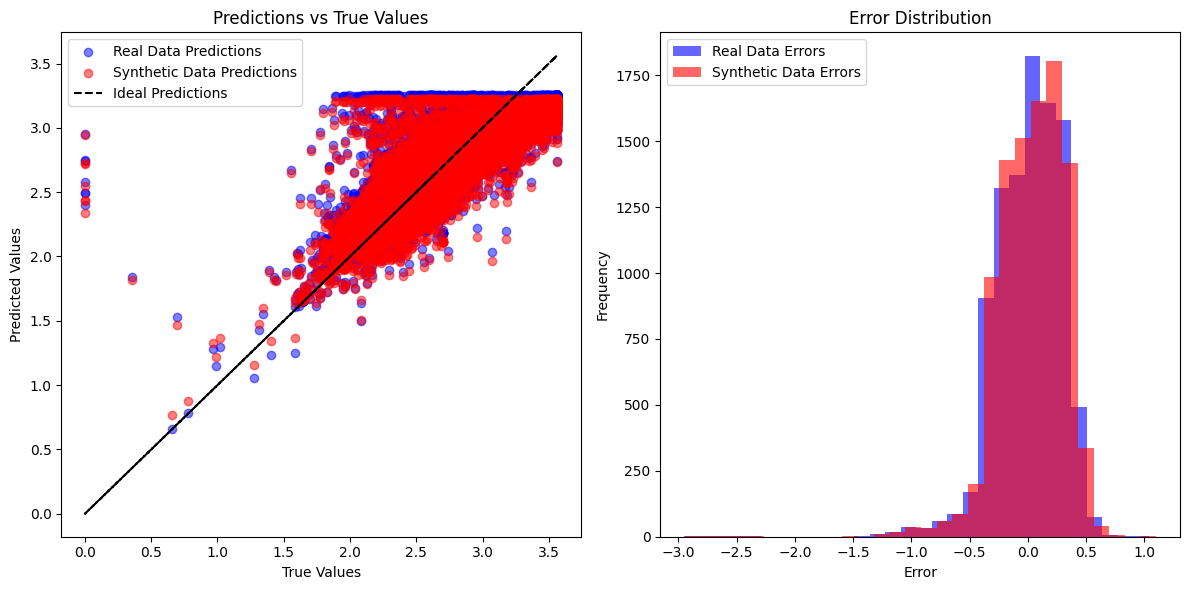

<ipython-input-2-0d253cd5aef2>:187: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="Source", y="NO", data=no_melt, inner="box", palette="Set2")


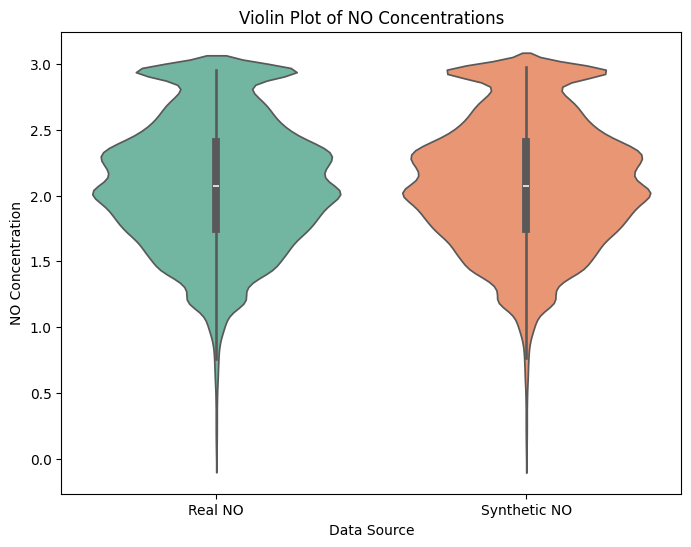

<ipython-input-2-0d253cd5aef2>:200: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="Source", y="NO2", data=no2_melt, inner="box", palette="Set2")


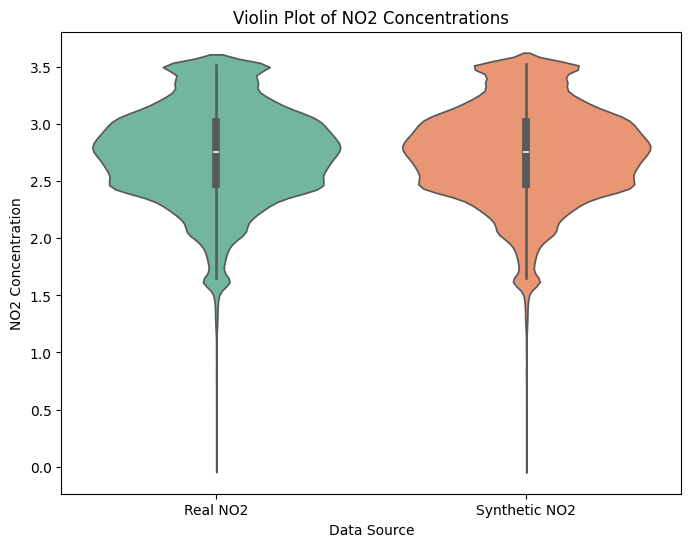

<ipython-input-2-0d253cd5aef2>:213: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="Source", y="NOx", data=nox_melt, inner="box", palette="Set2")


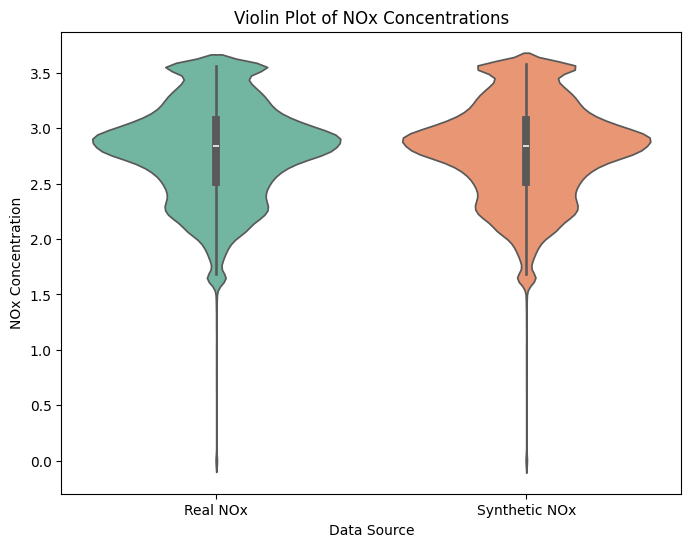

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------
# Data Preprocessing
# -------------------
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Chennai.csv")
# Update the date format to match your data (month-day-year)
df["Datetime"] = pd.to_datetime(df["Datetime"], format="%m-%d-%Y %H:%M")
df["Timestamp"] = df["Datetime"].astype('int64') // 10**9
df = df.drop(columns=["City", "Datetime"])

# Log transform skewed features
df["NO"] = np.log1p(df["NO"])
df["NO2"] = np.log1p(df["NO2"])
df["NOx"] = np.log1p(df["NOx"])

columns_to_use = ["NO", "NO2", "NOx"]
data = df[columns_to_use].values

scaler = StandardScaler()
normalized_data = scaler.fit_transform(data)
mean_vals = scaler.mean_
std_vals = np.sqrt(scaler.var_)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------------------
# Diffusion Model
# -------------------
class DiffusionModel(nn.Module):
    def __init__(self, input_dim):
        super(DiffusionModel, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.GELU(),
            nn.Dropout(0.1),  # Reduced dropout
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.GELU(),
            nn.Dropout(0.07),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.GELU(),
            nn.Dropout(0.05),
            nn.Linear(128, input_dim)
        )

    def forward(self, x, noise_level):
        return x + noise_level * self.net(x)

# -------------------
# Adaptive Noise Scaling
# -------------------
def adaptive_noise(epoch, total_epochs, max_noise=0.2, min_noise=0.02):
    """Cosine annealing noise decay with floor value."""
    return min_noise + 0.5 * (max_noise - min_noise) * (1 + np.cos(np.pi * epoch / total_epochs))

# -------------------
# Feature Matching Loss
# -------------------
def cosine_similarity_loss(real, fake):
    cos_sim = nn.functional.cosine_similarity(real, fake, dim=1).mean()
    return 1 - cos_sim  # Want values close to 0

# -------------------
# Training Function
# -------------------
def train_diffusion_model(data, epochs=3000, batch_size=10000, lr=5e-4):
    dataset = TensorDataset(torch.tensor(data, dtype=torch.float32))
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    model = DiffusionModel(data.shape[1]).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5000, eta_min=1e-6)
    mse_loss = nn.MSELoss()

    for epoch in range(epochs):
        epoch_loss = 0.0
        noise_level = adaptive_noise(epoch, epochs)

        model.train()
        for batch, in loader:
            batch = batch.to(device)
            noise = torch.randn_like(batch) * 0.05
            noisy_batch = batch + noise

            optimizer.zero_grad()
            fake_data = model(noisy_batch, noise_level)

            # --- Loss Function ---
            loss_MSE = mse_loss(fake_data, batch)
            loss_Cosine = cosine_similarity_loss(fake_data, batch)
            loss_total = loss_MSE + 0.5 * loss_Cosine  # Weighted feature loss

            loss_total.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            epoch_loss += loss_total.item() * batch.size(0)

        scheduler.step()
        if (epoch + 1) % 500 == 0:
            avg_loss = epoch_loss / len(dataset)
            print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, Noise Level: {noise_level:.4f}")

    return model

# -------------------
# Validate with MLPRegressor
# -------------------
def validate_synthetic_data(real_data, synthetic_data):
    X_real, y_real = real_data[:, :-1], real_data[:, -1]
    X_syn, y_syn = synthetic_data[:, :-1], synthetic_data[:, -1]

    # Split real data for training and testing
    X_train_real, X_test, y_train_real, y_test = train_test_split(X_real, y_real, test_size=0.2, random_state=42)

    # Train model on real data
    reg_real = MLPRegressor(hidden_layer_sizes=(128, 64), activation='relu', max_iter=500, random_state=42)
    reg_real.fit(X_train_real, y_train_real)
    real_predictions = reg_real.predict(X_test)

    # Train model on synthetic data
    reg_syn = MLPRegressor(hidden_layer_sizes=(128, 64), activation='relu', max_iter=500, random_state=42)
    reg_syn.fit(X_syn, y_syn)
    syn_predictions = reg_syn.predict(X_test)

    # Print real data performance
    print("\nReal Data Performance:")
    print(f"  MSE: {mean_squared_error(y_test, real_predictions):.4f}")
    print(f"  R²: {r2_score(y_test, real_predictions):.4f}")

    # Print synthetic data performance
    print("\nSynthetic Data Performance:")
    print(f"  MSE: {mean_squared_error(y_test, syn_predictions):.4f}")
    print(f"  R²: {r2_score(y_test, syn_predictions):.4f}")

    plt.figure(figsize=(12, 6))

    # Scatter Plot: Predictions vs True Values
    plt.subplot(1, 2, 1)
    plt.scatter(y_test, real_predictions, color='blue', alpha=0.5, label="Real Data Predictions")
    plt.scatter(y_test, syn_predictions, color='red', alpha=0.5, label="Synthetic Data Predictions")
    plt.plot(y_test, y_test, 'k--', label="Ideal Predictions")  # 45-degree line
    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")
    plt.legend()
    plt.title("Predictions vs True Values")

    # Histogram: Prediction Errors
    real_errors = y_test - real_predictions
    syn_errors = y_test - syn_predictions

    plt.subplot(1, 2, 2)
    plt.hist(real_errors, bins=30, alpha=0.6, color='blue', label="Real Data Errors")
    plt.hist(syn_errors, bins=30, alpha=0.6, color='red', label="Synthetic Data Errors")
    plt.xlabel("Error")
    plt.ylabel("Frequency")
    plt.legend()
    plt.title("Error Distribution")

    plt.tight_layout()
    plt.show()

# -------------------
# Visualization Functions for Pollutants
# -------------------
def plot_violin_NO(real_df, synthetic_df):
    plt.figure(figsize=(8, 6))
    no_df = pd.concat([
        real_df["NO"].rename("Real NO"),
        synthetic_df["NO"].rename("Synthetic NO")
    ], axis=1)
    no_melt = no_df.melt(var_name="Source", value_name="NO")
    sns.violinplot(x="Source", y="NO", data=no_melt, inner="box", palette="Set2")
    plt.title("Violin Plot of NO Concentrations")
    plt.xlabel("Data Source")
    plt.ylabel("NO Concentration")
    plt.show()

def plot_violin_NO2(real_df, synthetic_df):
    plt.figure(figsize=(8, 6))
    no2_df = pd.concat([
        real_df["NO2"].rename("Real NO2"),
        synthetic_df["NO2"].rename("Synthetic NO2")
    ], axis=1)
    no2_melt = no2_df.melt(var_name="Source", value_name="NO2")
    sns.violinplot(x="Source", y="NO2", data=no2_melt, inner="box", palette="Set2")
    plt.title("Violin Plot of NO2 Concentrations")
    plt.xlabel("Data Source")
    plt.ylabel("NO2 Concentration")
    plt.show()

def plot_violin_NOx(real_df, synthetic_df):
    plt.figure(figsize=(8, 6))
    nox_df = pd.concat([
        real_df["NOx"].rename("Real NOx"),
        synthetic_df["NOx"].rename("Synthetic NOx")
    ], axis=1)
    nox_melt = nox_df.melt(var_name="Source", value_name="NOx")
    sns.violinplot(x="Source", y="NOx", data=nox_melt, inner="box", palette="Set2")
    plt.title("Violin Plot of NOx Concentrations")
    plt.xlabel("Data Source")
    plt.ylabel("NOx Concentration")
    plt.show()

# -------------------
# Main Execution
# -------------------
model = train_diffusion_model(normalized_data)
synthetic_data = model(torch.tensor(normalized_data, dtype=torch.float32).to(device), noise_level=0.02).cpu().detach().numpy()
synthetic_data = synthetic_data * std_vals + mean_vals

validate_synthetic_data(data, synthetic_data)

# For visualization, create DataFrames for real and synthetic pollutants
real_df = pd.DataFrame(data, columns=columns_to_use)
synthetic_df = pd.DataFrame(synthetic_data, columns=columns_to_use)

# Plot separate graphs for each pollutant
plot_violin_NO(real_df, synthetic_df)
plot_violin_NO2(real_df, synthetic_df)
plot_violin_NOx(real_df, synthetic_df)

In [3]:
import pandas as pd

# Convert synthetic data to DataFrame
synthetic_df = pd.DataFrame(synthetic_data, columns=["NO", "NO2", "NOx"])

# Save to CSV
synthetic_df.to_csv("latest_synthetic_data.csv", index=False)

print("Synthetic data saved as 'synthetic_data.csv'")

Synthetic data saved as 'synthetic_data.csv'


Epoch 500, Loss: 0.0043, Noise Level: 0.1880
Epoch 1000, Loss: 0.0042, Noise Level: 0.1551
Epoch 1500, Loss: 0.0042, Noise Level: 0.1101
Epoch 2000, Loss: 0.0041, Noise Level: 0.0651
Epoch 2500, Loss: 0.0041, Noise Level: 0.0321
Epoch 3000, Loss: 0.0041, Noise Level: 0.0200

Real Data Performance:
  MSE: 0.2427
  R²: 0.5505

Synthetic Data Performance:
  MSE: 0.2406
  R²: 0.5545


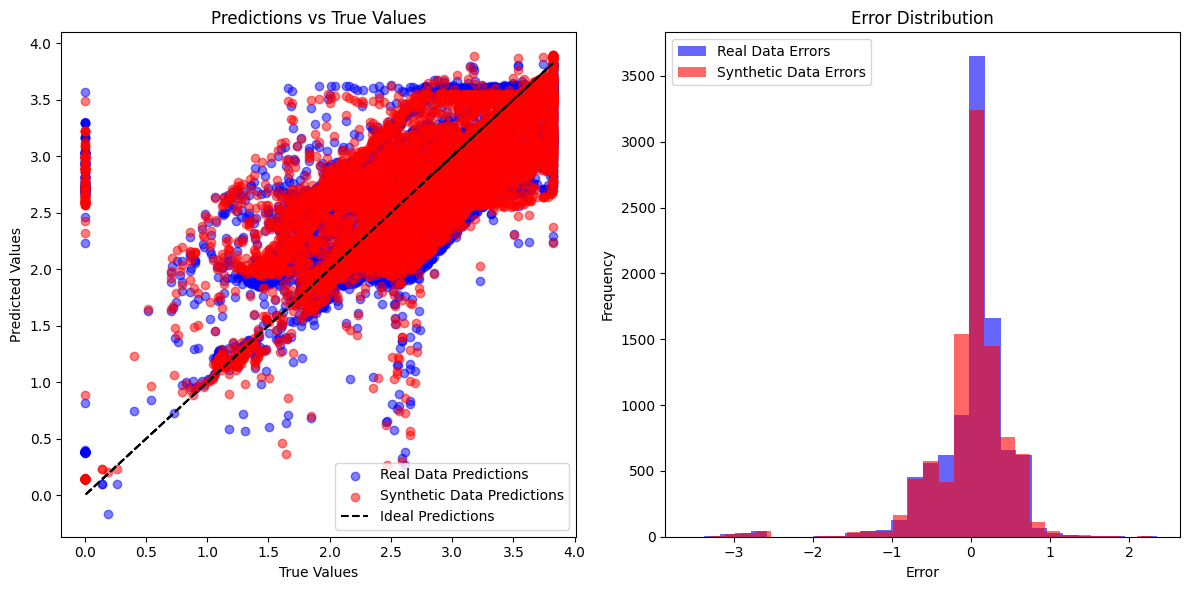

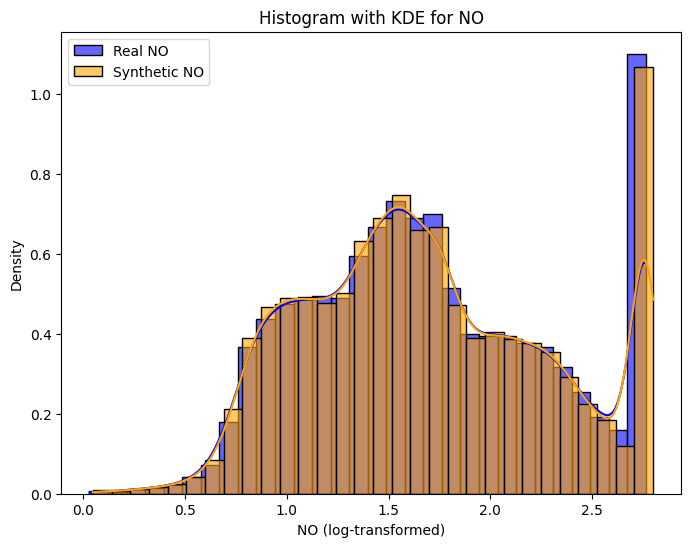

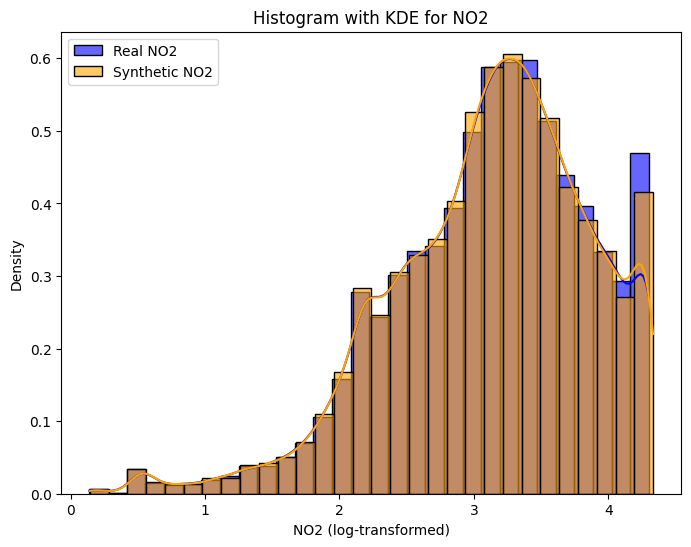

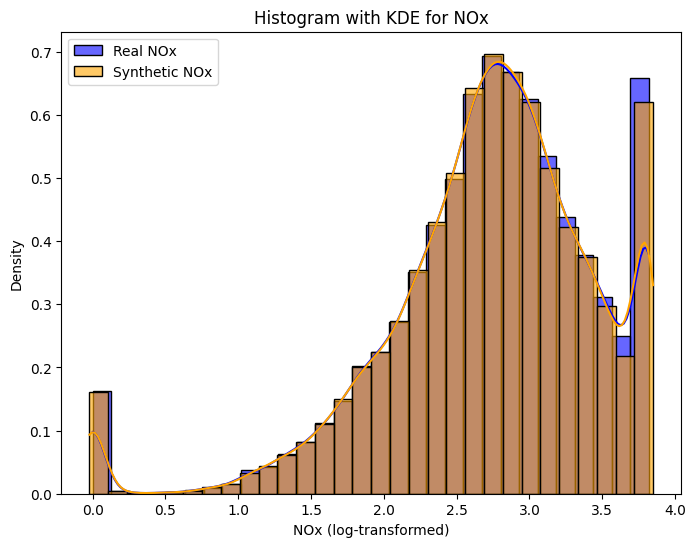

In [4]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------
# Data Preprocessing
# -------------------
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Hyderabad.csv")
# Updated to use month-day-year format for correct parsing
df["Datetime"] = pd.to_datetime(df["Datetime"], format="%d-%m-%Y %H:%M")
df["Timestamp"] = df["Datetime"].astype('int64') // 10**9
df = df.drop(columns=["City", "Datetime"])

# Log transform skewed features
df["NO"] = np.log1p(df["NO"])
df["NO2"] = np.log1p(df["NO2"])
df["NOx"] = np.log1p(df["NOx"])

columns_to_use = ["NO", "NO2", "NOx"]
data = df[columns_to_use].values

scaler = StandardScaler()
normalized_data = scaler.fit_transform(data)
mean_vals = scaler.mean_
std_vals = np.sqrt(scaler.var_)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------------------
# Diffusion Model
# -------------------
class DiffusionModel(nn.Module):
    def __init__(self, input_dim):
        super(DiffusionModel, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.GELU(),
            nn.Dropout(0.1),  # Reduced dropout
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.GELU(),
            nn.Dropout(0.07),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.GELU(),
            nn.Dropout(0.05),
            nn.Linear(128, input_dim)
        )

    def forward(self, x, noise_level):
        return x + noise_level * self.net(x)

# -------------------
# Adaptive Noise Scaling
# -------------------
def adaptive_noise(epoch, total_epochs, max_noise=0.2, min_noise=0.02):
    """Cosine annealing noise decay with floor value."""
    return min_noise + 0.5 * (max_noise - min_noise) * (1 + np.cos(np.pi * epoch / total_epochs))

# -------------------
# Feature Matching Loss
# -------------------
def cosine_similarity_loss(real, fake):
    cos_sim = nn.functional.cosine_similarity(real, fake, dim=1).mean()
    return 1 - cos_sim  # Want values close to 0

# -------------------
# Training Function
# -------------------
def train_diffusion_model(data, epochs=3000, batch_size=10000, lr=5e-4):
    dataset = TensorDataset(torch.tensor(data, dtype=torch.float32))
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    model = DiffusionModel(data.shape[1]).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5000, eta_min=1e-6)
    mse_loss = nn.MSELoss()

    for epoch in range(epochs):
        epoch_loss = 0.0
        noise_level = adaptive_noise(epoch, epochs)

        model.train()
        for batch, in loader:
            batch = batch.to(device)
            noise = torch.randn_like(batch) * 0.05
            noisy_batch = batch + noise

            optimizer.zero_grad()
            fake_data = model(noisy_batch, noise_level)

            loss_MSE = mse_loss(fake_data, batch)
            loss_Cosine = cosine_similarity_loss(fake_data, batch)
            loss_total = loss_MSE + 0.5 * loss_Cosine

            loss_total.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            epoch_loss += loss_total.item() * batch.size(0)

        scheduler.step()
        if (epoch + 1) % 500 == 0:
            avg_loss = epoch_loss / len(dataset)
            print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, Noise Level: {noise_level:.4f}")

    return model

# -------------------
# Validate with MLPRegressor
# -------------------
def validate_synthetic_data(real_data, synthetic_data):
    X_real, y_real = real_data[:, :-1], real_data[:, -1]
    X_syn, y_syn = synthetic_data[:, :-1], synthetic_data[:, -1]

    X_train_real, X_test, y_train_real, y_test = train_test_split(X_real, y_real, test_size=0.2, random_state=42)

    reg_real = MLPRegressor(hidden_layer_sizes=(128, 64), activation='relu', max_iter=500, random_state=42)
    reg_real.fit(X_train_real, y_train_real)
    real_predictions = reg_real.predict(X_test)

    reg_syn = MLPRegressor(hidden_layer_sizes=(128, 64), activation='relu', max_iter=500, random_state=42)
    reg_syn.fit(X_syn, y_syn)
    syn_predictions = reg_syn.predict(X_test)

    print("\nReal Data Performance:")
    print(f"  MSE: {mean_squared_error(y_test, real_predictions):.4f}")
    print(f"  R²: {r2_score(y_test, real_predictions):.4f}")

    print("\nSynthetic Data Performance:")
    print(f"  MSE: {mean_squared_error(y_test, syn_predictions):.4f}")
    print(f"  R²: {r2_score(y_test, syn_predictions):.4f}")

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.scatter(y_test, real_predictions, color='blue', alpha=0.5, label="Real Data Predictions")
    plt.scatter(y_test, syn_predictions, color='red', alpha=0.5, label="Synthetic Data Predictions")
    plt.plot(y_test, y_test, 'k--', label="Ideal Predictions")
    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")
    plt.legend()
    plt.title("Predictions vs True Values")

    real_errors = y_test - real_predictions
    syn_errors = y_test - syn_predictions

    plt.subplot(1, 2, 2)
    plt.hist(real_errors, bins=30, alpha=0.6, color='blue', label="Real Data Errors")
    plt.hist(syn_errors, bins=30, alpha=0.6, color='red', label="Synthetic Data Errors")
    plt.xlabel("Error")
    plt.ylabel("Frequency")
    plt.legend()
    plt.title("Error Distribution")

    plt.tight_layout()
    plt.show()

# -------------------
# Visualization Functions for Each Pollutant
# -------------------
def plot_histogram_kde_NO(real_df, synthetic_df):
    plt.figure(figsize=(8,6))
    sns.histplot(real_df["NO"], color="blue", label="Real NO", kde=True, stat='density', bins=30, alpha=0.6)
    sns.histplot(synthetic_df["NO"], color="orange", label="Synthetic NO", kde=True, stat='density', bins=30, alpha=0.6)
    plt.title("Histogram with KDE for NO")
    plt.xlabel("NO (log-transformed)")
    plt.ylabel("Density")
    plt.legend()
    plt.show()

def plot_histogram_kde_NO2(real_df, synthetic_df):
    plt.figure(figsize=(8,6))
    sns.histplot(real_df["NO2"], color="blue", label="Real NO2", kde=True, stat='density', bins=30, alpha=0.6)
    sns.histplot(synthetic_df["NO2"], color="orange", label="Synthetic NO2", kde=True, stat='density', bins=30, alpha=0.6)
    plt.title("Histogram with KDE for NO2")
    plt.xlabel("NO2 (log-transformed)")
    plt.ylabel("Density")
    plt.legend()
    plt.show()

def plot_histogram_kde_NOx(real_df, synthetic_df):
    plt.figure(figsize=(8,6))
    sns.histplot(real_df["NOx"], color="blue", label="Real NOx", kde=True, stat='density', bins=30, alpha=0.6)
    sns.histplot(synthetic_df["NOx"], color="orange", label="Synthetic NOx", kde=True, stat='density', bins=30, alpha=0.6)
    plt.title("Histogram with KDE for NOx")
    plt.xlabel("NOx (log-transformed)")
    plt.ylabel("Density")
    plt.legend()
    plt.show()

# -------------------
# Main Execution
# -------------------
model = train_diffusion_model(normalized_data)
synthetic_data = model(torch.tensor(normalized_data, dtype=torch.float32).to(device), noise_level=0.02).cpu().detach().numpy()
synthetic_data = synthetic_data * std_vals + mean_vals

validate_synthetic_data(data, synthetic_data)

# Create DataFrames for visualization from real and synthetic data
real_df = pd.DataFrame(data, columns=columns_to_use)
synthetic_df = pd.DataFrame(synthetic_data, columns=columns_to_use)

# Generate plots for each pollutant as described:
# Histogram/KDE for NO
plot_histogram_kde_NO(real_df, synthetic_df)

# Box Plot for NO2
plot_histogram_kde_NO2(real_df, synthetic_df)

# Scatter Plot for NOx
plot_histogram_kde_NOx(real_df, synthetic_df)

In [6]:
import pandas as pd

# Convert synthetic data to DataFrame
synthetic_df = pd.DataFrame(synthetic_data, columns=["NO", "NO2", "NOx"])

# Save to CSV
synthetic_df.to_csv("latest_synthetic_data.csv", index=False)

print("Synthetic data saved as 'synthetic_data.csv'")

Synthetic data saved as 'synthetic_data.csv'


In [7]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# -------------------
# Data Preprocessing
# -------------------
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/bangalore.csv")
# Updated to use month-day-year format for correct parsing
df["Datetime"] = df["Datetime"].str.replace(r"(\d{2})-(\d{2})$", r"\1:\2", regex=True)
df["Datetime"] = pd.to_datetime(df["Datetime"], format="%m-%d-%Y %H:%M")
df["Timestamp"] = df["Datetime"].astype('int64') // 10**9
df = df.drop(columns=["City", "Datetime"])

# Log transform skewed features
df["NO"] = np.log1p(df["NO"])
df["NO2"] = np.log1p(df["NO2"])
df["NOx"] = np.log1p(df["NOx"])

columns_to_use = ["NO", "NO2", "NOx"]
data = df[columns_to_use].values

scaler = StandardScaler()
normalized_data = scaler.fit_transform(data)
mean_vals = scaler.mean_
std_vals = np.sqrt(scaler.var_)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------------------
# Diffusion Model
# -------------------
class DiffusionModel(nn.Module):
    def __init__(self, input_dim):
        super(DiffusionModel, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.GELU(),
            nn.Dropout(0.1),  # Reduced dropout
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.GELU(),
            nn.Dropout(0.07),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.GELU(),
            nn.Dropout(0.05),
            nn.Linear(128, input_dim)
        )

    def forward(self, x, noise_level):
        return x + noise_level * self.net(x)

# -------------------
# Adaptive Noise Scaling
# -------------------
def adaptive_noise(epoch, total_epochs, max_noise=0.2, min_noise=0.02):
    """Cosine annealing noise decay with floor value."""
    return min_noise + 0.5 * (max_noise - min_noise) * (1 + np.cos(np.pi * epoch / total_epochs))

# -------------------
# Feature Matching Loss
# -------------------
def cosine_similarity_loss(real, fake):
    cos_sim = nn.functional.cosine_similarity(real, fake, dim=1).mean()
    return 1 - cos_sim  # Want values close to 0

# -------------------
# Training Function
# -------------------
def train_diffusion_model(data, epochs=3000, batch_size=10000, lr=5e-4):
    dataset = TensorDataset(torch.tensor(data, dtype=torch.float32))
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    model = DiffusionModel(data.shape[1]).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5000, eta_min=1e-6)
    mse_loss = nn.MSELoss()

    for epoch in range(epochs):
        epoch_loss = 0.0
        noise_level = adaptive_noise(epoch, epochs)

        model.train()
        for batch, in loader:
            batch = batch.to(device)
            noise = torch.randn_like(batch) * 0.05
            noisy_batch = batch + noise

            optimizer.zero_grad()
            fake_data = model(noisy_batch, noise_level)

            loss_MSE = mse_loss(fake_data, batch)
            loss_Cosine = cosine_similarity_loss(fake_data, batch)
            loss_total = loss_MSE + 0.5 * loss_Cosine

            loss_total.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            epoch_loss += loss_total.item() * batch.size(0)

        scheduler.step()
        if (epoch + 1) % 500 == 0:
            avg_loss = epoch_loss / len(dataset)
            print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, Noise Level: {noise_level:.4f}")

    return model

# -------------------
# Validate with MLPRegressor
# -------------------
def validate_synthetic_data(real_data, synthetic_data):
    X_real, y_real = real_data[:, :-1], real_data[:, -1]
    X_syn, y_syn = synthetic_data[:, :-1], synthetic_data[:, -1]

    X_train_real, X_test, y_train_real, y_test = train_test_split(X_real, y_real, test_size=0.2, random_state=42)

    reg_real = MLPRegressor(hidden_layer_sizes=(128, 64), activation='relu', max_iter=500, random_state=42)
    reg_real.fit(X_train_real, y_train_real)
    real_predictions = reg_real.predict(X_test)

    reg_syn = MLPRegressor(hidden_layer_sizes=(128, 64), activation='relu', max_iter=500, random_state=42)
    reg_syn.fit(X_syn, y_syn)
    syn_predictions = reg_syn.predict(X_test)

    print("\nReal Data Performance:")
    print(f"  MSE: {mean_squared_error(y_test, real_predictions):.4f}")
    print(f"  R²: {r2_score(y_test, real_predictions):.4f}")

    print("\nSynthetic Data Performance:")
    print(f"  MSE: {mean_squared_error(y_test, syn_predictions):.4f}")
    print(f"  R²: {r2_score(y_test, syn_predictions):.4f}")

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.scatter(y_test, real_predictions, color='blue', alpha=0.5, label="Real Data Predictions")
    plt.scatter(y_test, syn_predictions, color='red', alpha=0.5, label="Synthetic Data Predictions")
    plt.plot(y_test, y_test, 'k--', label="Ideal Predictions")
    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")
    plt.legend()
    plt.title("Predictions vs True Values")

    real_errors = y_test - real_predictions
    syn_errors = y_test - syn_predictions
    plt.subplot(1, 2, 2)
    plt.hist(real_errors, bins=30, alpha=0.6, color='blue', label="Real Data Errors")
    plt.hist(syn_errors, bins=30, alpha=0.6, color='red', label="Synthetic Data Errors")
    plt.xlabel("Error")
    plt.ylabel("Frequency")
    plt.legend()
    plt.title("Error Distribution")

    plt.tight_layout()
    plt.show()

# -------------------
# Alternative Interactive Visualizations using Plotly
# -------------------

# 1. Strip Plot for NO with Jitter
import plotly.express as px

def plot_strip_NO(real_df, synthetic_df):
    # Combine real and synthetic data for NO
    df_strip = pd.concat([
        real_df[["NO"]].assign(Source="Real NO"),
        synthetic_df[["NO"]].assign(Source="Synthetic NO")
    ], ignore_index=True)

    # Create the strip plot
    fig = px.strip(df_strip, x="Source", y="NO", color="Source",
                   title="Interactive Strip Plot for NO",
                   template="plotly_white")

    # Add jitter using update_traces
    fig.update_traces(jitter=0.4)

    # Show the figure
    fig.show()

def plot_strip_NO2(real_df, synthetic_df):
    # Combine real and synthetic data for NO
    df_strip = pd.concat([
        real_df[["NO2"]].assign(Source="Real NO2"),
        synthetic_df[["NO2"]].assign(Source="Synthetic NO2")
    ], ignore_index=True)

    # Create the strip plot
    fig = px.strip(df_strip, x="Source", y="NO2", color="Source",
                   title="Interactive Strip Plot for NO2",
                   template="plotly_white")

    # Add jitter using update_traces
    fig.update_traces(jitter=0.4)

    # Show the figure
    fig.show()

def plot_strip_NOx(real_df, synthetic_df):
    # Combine real and synthetic data for NO
    df_strip = pd.concat([
        real_df[["NOx"]].assign(Source="Real NOx"),
        synthetic_df[["NOx"]].assign(Source="Synthetic NOx")
    ], ignore_index=True)

    # Create the strip plot
    fig = px.strip(df_strip, x="Source", y="NOx", color="Source",
                   title="Interactive Strip Plot for NOx",
                   template="plotly_white")

    # Add jitter using update_traces
    fig.update_traces(jitter=0.4)

    # Show the figure
    fig.show()

# -------------------
# Main Execution
# -------------------
model = train_diffusion_model(normalized_data)
synthetic_data = model(torch.tensor(normalized_data, dtype=torch.float32).to(device), noise_level=0.02).cpu().detach().numpy()
synthetic_data = synthetic_data * std_vals + mean_vals

validate_synthetic_data(data, synthetic_data)

# Prepare DataFrames for visualization from real and synthetic data
real_df = pd.DataFrame(data, columns=columns_to_use)
synthetic_df = pd.DataFrame(synthetic_data, columns=columns_to_use)

# Generate the new interactive plots:
plot_strip_NO(real_df, synthetic_df)       # Strip plot for NO
plot_strip_NO2(real_df, synthetic_df)
plot_strip_NOx(real_df, synthetic_df)

Output hidden; open in https://colab.research.google.com to view.

In [8]:
import pandas as pd

# Convert synthetic data to DataFrame
synthetic_df = pd.DataFrame(synthetic_data, columns=["NO", "NO2", "NOx"])

# Save to CSV
synthetic_df.to_csv("latest_synthetic_data.csv", index=False)

print("Synthetic data saved as 'synthetic_data.csv'")

Synthetic data saved as 'synthetic_data.csv'


Epoch 500, Loss: 0.0044, Noise Level: 0.1880
Epoch 1000, Loss: 0.0042, Noise Level: 0.1551
Epoch 1500, Loss: 0.0043, Noise Level: 0.1101
Epoch 2000, Loss: 0.0045, Noise Level: 0.0651
Epoch 2500, Loss: 0.0042, Noise Level: 0.0321
Epoch 3000, Loss: 0.0042, Noise Level: 0.0200

Real Data Performance:
  MSE: 0.0784
  R²: 0.8394

Synthetic Data Performance:
  MSE: 0.0720
  R²: 0.8525


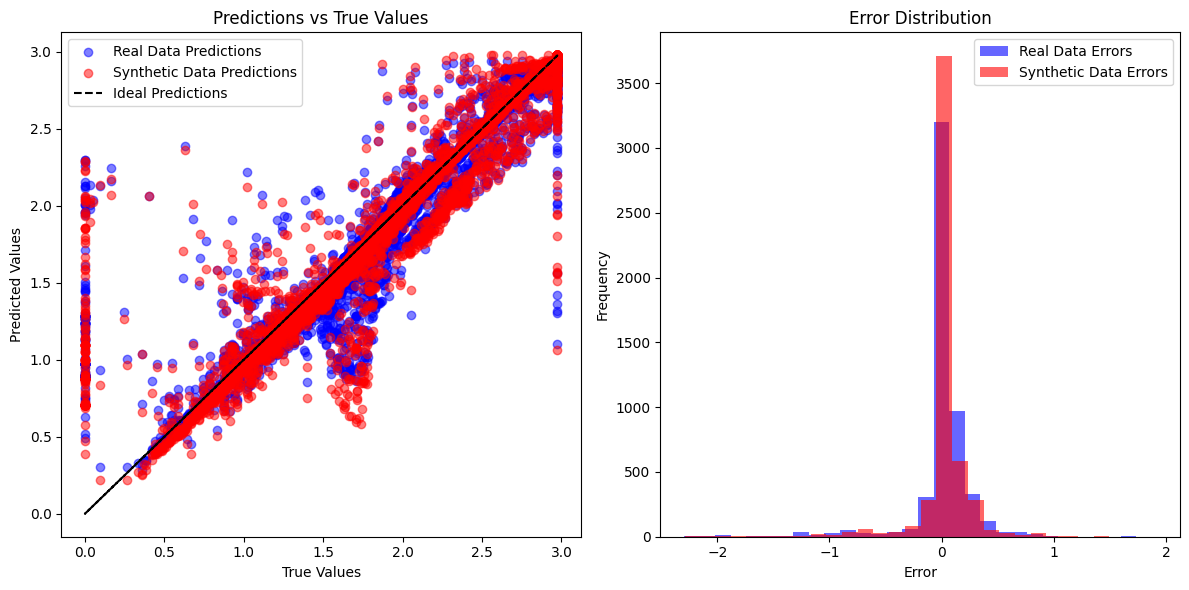

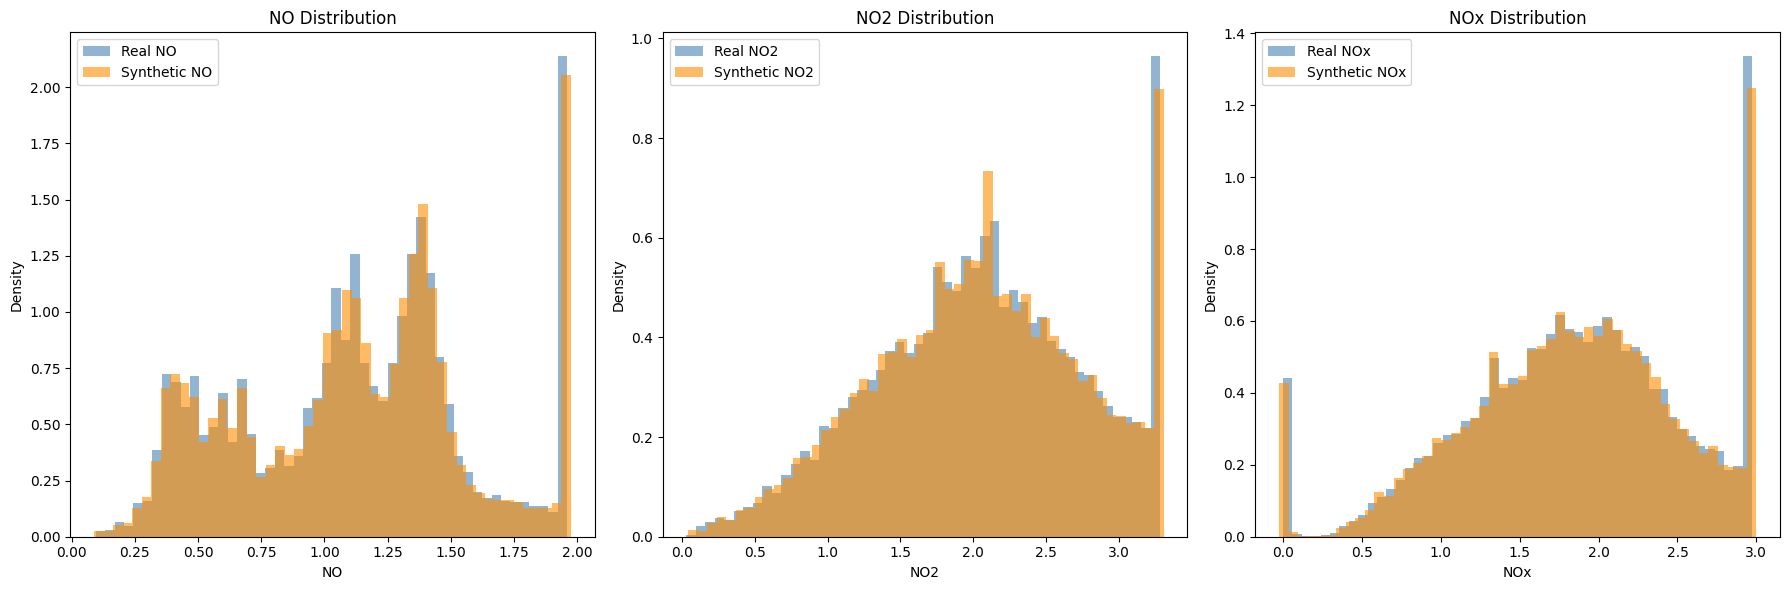

In [9]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# -------------------
# Data Preprocessing
# -------------------
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Thiruvananthapuram.csv")
df["Datetime"] = pd.to_datetime(df["Datetime"], format="%d-%m-%Y %H:%M")
df["Timestamp"] = df["Datetime"].astype('int64') // 10**9
df = df.drop(columns=["City", "Datetime"])

# Log transform skewed features
df["NO"] = np.log1p(df["NO"])
df["NO2"] = np.log1p(df["NO2"])
df["NOx"] = np.log1p(df["NOx"])

columns_to_use = ["NO", "NO2", "NOx"]
data = df[columns_to_use].values

scaler = StandardScaler()
normalized_data = scaler.fit_transform(data)
mean_vals = scaler.mean_
std_vals = np.sqrt(scaler.var_)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------------------
# Diffusion Model
# -------------------
class DiffusionModel(nn.Module):
    def __init__(self, input_dim):
        super(DiffusionModel, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.GELU(),
            nn.Dropout(0.1),  # Reduced dropout
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.GELU(),
            nn.Dropout(0.07),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.GELU(),
            nn.Dropout(0.05),
            nn.Linear(128, input_dim)
        )

    def forward(self, x, noise_level):
        return x + noise_level * self.net(x)

# -------------------
# Adaptive Noise Scaling
# -------------------
def adaptive_noise(epoch, total_epochs, max_noise=0.2, min_noise=0.02):
    """Cosine annealing noise decay with floor value."""
    return min_noise + 0.5 * (max_noise - min_noise) * (1 + np.cos(np.pi * epoch / total_epochs))

# -------------------
# Feature Matching Loss
# -------------------
def cosine_similarity_loss(real, fake):
    cos_sim = nn.functional.cosine_similarity(real, fake, dim=1).mean()
    return 1 - cos_sim  # Want values close to 0

# -------------------
# Training Function
# -------------------
def train_diffusion_model(data, epochs=3000, batch_size=10000, lr=5e-4):
    dataset = TensorDataset(torch.tensor(data, dtype=torch.float32))
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    model = DiffusionModel(data.shape[1]).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5000, eta_min=1e-6)
    mse_loss = nn.MSELoss()

    for epoch in range(epochs):
        epoch_loss = 0.0
        noise_level = adaptive_noise(epoch, epochs)

        model.train()
        for batch, in loader:
            batch = batch.to(device)
            noise = torch.randn_like(batch) * 0.05
            noisy_batch = batch + noise

            optimizer.zero_grad()
            fake_data = model(noisy_batch, noise_level)

            # --- Loss Function ---
            loss_MSE = mse_loss(fake_data, batch)
            loss_Cosine = cosine_similarity_loss(fake_data, batch)
            loss_total = loss_MSE + 0.5 * loss_Cosine  # Weighted feature loss

            loss_total.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            epoch_loss += loss_total.item() * batch.size(0)

        scheduler.step()
        if (epoch + 1) % 500 == 0:
            avg_loss = epoch_loss / len(dataset)
            print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, Noise Level: {noise_level:.4f}")

    return model

# -------------------
# Validate with MLPRegressor
# -------------------
# -------------------
# Validate with MLPRegressor
# -------------------
def validate_synthetic_data(real_data, synthetic_data):
    X_real, y_real = real_data[:, :-1], real_data[:, -1]
    X_syn, y_syn = synthetic_data[:, :-1], synthetic_data[:, -1]

    # Split real data for training and testing
    X_train_real, X_test, y_train_real, y_test = train_test_split(X_real, y_real, test_size=0.2, random_state=42)

    # Train model on real data
    reg_real = MLPRegressor(hidden_layer_sizes=(128, 64), activation='relu', max_iter=500, random_state=42)
    reg_real.fit(X_train_real, y_train_real)
    real_predictions = reg_real.predict(X_test)

    # Train model on synthetic data
    reg_syn = MLPRegressor(hidden_layer_sizes=(128, 64), activation='relu', max_iter=500, random_state=42)
    reg_syn.fit(X_syn, y_syn)
    syn_predictions = reg_syn.predict(X_test)

    # Print real data performance
    print("\nReal Data Performance:")
    print(f"  MSE: {mean_squared_error(y_test, real_predictions):.4f}")
    print(f"  R²: {r2_score(y_test, real_predictions):.4f}")

    # Print synthetic data performance
    print("\nSynthetic Data Performance:")
    print(f"  MSE: {mean_squared_error(y_test, syn_predictions):.4f}")
    print(f"  R²: {r2_score(y_test, syn_predictions):.4f}")

    plt.figure(figsize=(12, 6))

    # Scatter Plot: Predictions vs True Values
    plt.subplot(1, 2, 1)
    plt.scatter(y_test, real_predictions, color='blue', alpha=0.5, label="Real Data Predictions")
    plt.scatter(y_test, syn_predictions, color='red', alpha=0.5, label="Synthetic Data Predictions")
    plt.plot(y_test, y_test, 'k--', label="Ideal Predictions")  # 45-degree line
    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")
    plt.legend()
    plt.title("Predictions vs True Values")

    # Histogram: Prediction Errors
    real_errors = y_test - real_predictions
    syn_errors = y_test - syn_predictions

    plt.subplot(1, 2, 2)
    plt.hist(real_errors, bins=30, alpha=0.6, color='blue', label="Real Data Errors")
    plt.hist(syn_errors, bins=30, alpha=0.6, color='red', label="Synthetic Data Errors")
    plt.xlabel("Error")
    plt.ylabel("Frequency")
    plt.legend()
    plt.title("Error Distribution")

    plt.tight_layout()
    plt.show()

def plot_pollutant_distributions(real_data, synthetic_data, columns=["NO", "NO2", "NOx"]):
    plt.figure(figsize=(18, 6))
    for i, col in enumerate(columns):
        plt.subplot(1, len(columns), i+1)
        plt.hist(real_data[:, i], bins=50, alpha=0.6, density=True, label=f"Real {col}", color='steelblue')
        plt.hist(synthetic_data[:, i], bins=50, alpha=0.6, density=True, label=f"Synthetic {col}", color='darkorange')
        plt.title(f"{col} Distribution")
        plt.xlabel(col)
        plt.ylabel("Density")
        plt.legend()
    plt.tight_layout()
    plt.show()


# -------------------
# Main Execution
# -------------------
model = train_diffusion_model(normalized_data)
synthetic_data = model(torch.tensor(normalized_data, dtype=torch.float32).to(device), noise_level=0.02).cpu().detach().numpy()
synthetic_data = synthetic_data * std_vals + mean_vals

validate_synthetic_data(data, synthetic_data)
plot_pollutant_distributions(data, synthetic_data)

In [10]:
import pandas as pd

# Convert synthetic data to DataFrame
synthetic_df = pd.DataFrame(synthetic_data, columns=["NO", "NO2", "NOx"])

# Save to CSV
synthetic_df.to_csv("latest_synthetic_data.csv", index=False)

print("Synthetic data saved as 'synthetic_data.csv'")

Synthetic data saved as 'synthetic_data.csv'


In [11]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# -------------------
# Data Preprocessing
# -------------------
df = pd.read_csv("/content/drive/MyDrive/amaravati.csv")
# Updated to use month-day-year format for correct parsing
df["Datetime"] = pd.to_datetime(df["Datetime"], format="%m-%d-%Y %H:%M")
df["Timestamp"] = df["Datetime"].astype('int64') // 10**9
df = df.drop(columns=["City", "Datetime"])

# Log transform skewed features
df["NO"] = np.log1p(df["NO"])
df["NO2"] = np.log1p(df["NO2"])
df["NOx"] = np.log1p(df["NOx"])

columns_to_use = ["NO", "NO2", "NOx"]
data = df[columns_to_use].values

scaler = StandardScaler()
normalized_data = scaler.fit_transform(data)
mean_vals = scaler.mean_
std_vals = np.sqrt(scaler.var_)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------------------
# Diffusion Model
# -------------------
class DiffusionModel(nn.Module):
    def __init__(self, input_dim):
        super(DiffusionModel, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.GELU(),
            nn.Dropout(0.1),  # Reduced dropout
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.GELU(),
            nn.Dropout(0.07),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.GELU(),
            nn.Dropout(0.05),
            nn.Linear(128, input_dim)
        )

    def forward(self, x, noise_level):
        return x + noise_level * self.net(x)

# -------------------
# Adaptive Noise Scaling
# -------------------
def adaptive_noise(epoch, total_epochs, max_noise=0.2, min_noise=0.02):
    """Cosine annealing noise decay with floor value."""
    return min_noise + 0.5 * (max_noise - min_noise) * (1 + np.cos(np.pi * epoch / total_epochs))

# -------------------
# Feature Matching Loss
# -------------------
def cosine_similarity_loss(real, fake):
    cos_sim = nn.functional.cosine_similarity(real, fake, dim=1).mean()
    return 1 - cos_sim  # Want values close to 0

# -------------------
# Training Function
# -------------------
def train_diffusion_model(data, epochs=3000, batch_size=10000, lr=5e-4):
    dataset = TensorDataset(torch.tensor(data, dtype=torch.float32))
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    model = DiffusionModel(data.shape[1]).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5000, eta_min=1e-6)
    mse_loss = nn.MSELoss()

    for epoch in range(epochs):
        epoch_loss = 0.0
        noise_level = adaptive_noise(epoch, epochs)

        model.train()
        for batch, in loader:
            batch = batch.to(device)
            noise = torch.randn_like(batch) * 0.05
            noisy_batch = batch + noise

            optimizer.zero_grad()
            fake_data = model(noisy_batch, noise_level)

            loss_MSE = mse_loss(fake_data, batch)
            loss_Cosine = cosine_similarity_loss(fake_data, batch)
            loss_total = loss_MSE + 0.5 * loss_Cosine

            loss_total.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            epoch_loss += loss_total.item() * batch.size(0)

        scheduler.step()
        if (epoch + 1) % 500 == 0:
            avg_loss = epoch_loss / len(dataset)
            print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, Noise Level: {noise_level:.4f}")

    return model

# -------------------
# Validate with MLPRegressor
# -------------------
def validate_synthetic_data(real_data, synthetic_data):
    X_real, y_real = real_data[:, :-1], real_data[:, -1]
    X_syn, y_syn = synthetic_data[:, :-1], synthetic_data[:, -1]

    X_train_real, X_test, y_train_real, y_test = train_test_split(X_real, y_real, test_size=0.2, random_state=42)

    reg_real = MLPRegressor(hidden_layer_sizes=(128, 64), activation='relu', max_iter=500, random_state=42)
    reg_real.fit(X_train_real, y_train_real)
    real_predictions = reg_real.predict(X_test)

    reg_syn = MLPRegressor(hidden_layer_sizes=(128, 64), activation='relu', max_iter=500, random_state=42)
    reg_syn.fit(X_syn, y_syn)
    syn_predictions = reg_syn.predict(X_test)

    print("\nReal Data Performance:")
    print(f"  MSE: {mean_squared_error(y_test, real_predictions):.4f}")
    print(f"  R²: {r2_score(y_test, real_predictions):.4f}")

    print("\nSynthetic Data Performance:")
    print(f"  MSE: {mean_squared_error(y_test, syn_predictions):.4f}")
    print(f"  R²: {r2_score(y_test, syn_predictions):.4f}")

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.scatter(y_test, real_predictions, color='blue', alpha=0.5, label="Real Data Predictions")
    plt.scatter(y_test, syn_predictions, color='red', alpha=0.5, label="Synthetic Data Predictions")
    plt.plot(y_test, y_test, 'k--', label="Ideal Predictions")
    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")
    plt.legend()
    plt.title("Predictions vs True Values")

    real_errors = y_test - real_predictions
    syn_errors = y_test - syn_predictions
    plt.subplot(1, 2, 2)
    plt.hist(real_errors, bins=30, alpha=0.6, color='blue', label="Real Data Errors")
    plt.hist(syn_errors, bins=30, alpha=0.6, color='red', label="Synthetic Data Errors")
    plt.xlabel("Error")
    plt.ylabel("Frequency")
    plt.legend()
    plt.title("Error Distribution")

    plt.tight_layout()
    plt.show()

# -------------------
# Alternative Interactive Visualizations using Plotly
# -------------------

# 1. Strip Plot for NO with Jitter
import plotly.express as px

def plot_strip_NO(real_df, synthetic_df):
    # Combine real and synthetic data for NO
    df_strip = pd.concat([
        real_df[["NO"]].assign(Source="Real NO"),
        synthetic_df[["NO"]].assign(Source="Synthetic NO")
    ], ignore_index=True)

    # Create the strip plot
    fig = px.strip(df_strip, x="Source", y="NO", color="Source",
                   title="Interactive Strip Plot for NO",
                   template="plotly_white")

    # Add jitter using update_traces
    fig.update_traces(jitter=0.4)

    # Show the figure
    fig.show()

def plot_strip_NO2(real_df, synthetic_df):
    # Combine real and synthetic data for NO
    df_strip = pd.concat([
        real_df[["NO2"]].assign(Source="Real NO2"),
        synthetic_df[["NO2"]].assign(Source="Synthetic NO2")
    ], ignore_index=True)

    # Create the strip plot
    fig = px.strip(df_strip, x="Source", y="NO2", color="Source",
                   title="Interactive Strip Plot for NO2",
                   template="plotly_white")

    # Add jitter using update_traces
    fig.update_traces(jitter=0.4)

    # Show the figure
    fig.show()

def plot_strip_NOx(real_df, synthetic_df):
    # Combine real and synthetic data for NO
    df_strip = pd.concat([
        real_df[["NOx"]].assign(Source="Real NOx"),
        synthetic_df[["NOx"]].assign(Source="Synthetic NOx")
    ], ignore_index=True)

    # Create the strip plot
    fig = px.strip(df_strip, x="Source", y="NOx", color="Source",
                   title="Interactive Strip Plot for NOx",
                   template="plotly_white")

    # Add jitter using update_traces
    fig.update_traces(jitter=0.4)

    # Show the figure
    fig.show()

# -------------------
# Main Execution
# -------------------
model = train_diffusion_model(normalized_data)
synthetic_data = model(torch.tensor(normalized_data, dtype=torch.float32).to(device), noise_level=0.02).cpu().detach().numpy()
synthetic_data = synthetic_data * std_vals + mean_vals

validate_synthetic_data(data, synthetic_data)

# Prepare DataFrames for visualization from real and synthetic data
real_df = pd.DataFrame(data, columns=columns_to_use)
synthetic_df = pd.DataFrame(synthetic_data, columns=columns_to_use)

# Generate the new interactive plots:
plot_strip_NO(real_df, synthetic_df)       # Strip plot for NO
plot_strip_NO2(real_df, synthetic_df)
plot_strip_NOx(real_df, synthetic_df)

Output hidden; open in https://colab.research.google.com to view.

In [12]:
import pandas as pd

# Convert synthetic data to DataFrame
synthetic_df = pd.DataFrame(synthetic_data, columns=["NO", "NO2", "NOx"])

# Save to CSV
synthetic_df.to_csv("latest_synthetic_data.csv", index=False)

print("Synthetic data saved as 'synthetic_data.csv'")

Synthetic data saved as 'synthetic_data.csv'
